# Commodity crack spread statistical arbitrage

In this notebook, the mean-rereversion strategy proposed in Girma and Paulson 1999 (henthforth GP1999) is investigated. It focuses on a various combination of the crude oil (WTI) crack spread. 

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import BacktestEngine, signal, InstrumentDef
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import get_futures_curve_snapshot
from vivace.backtest.stats import Performance
from vivace.enums import Strategy, Weighting, RollRule

# Cointegration test

GP1999 first checks if the crack spread is cointegrated. To do that, first let's see futures prices are non-stationary or not. As per usual, the generic price is populated by running a simple long-only backtest by rolling the front contract.

## ADF test

The ADF test is done by the `adfuller` function in `statsmodels`. (cf. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [2]:
cl_1st = BacktestEngine(instrument='CL', log_level=logging.WARN)
cl_1st.run()

In [3]:
ho_1st = BacktestEngine(instrument='HO', log_level=logging.WARN)
ho_1st.run()

In [4]:
xb_1st = BacktestEngine(instrument='XB', log_level=logging.WARN)
xb_1st.run()

In [5]:
cl_price = cl_1st.get_generic_price().squeeze().fillna(method='pad').rename('Crude oil')
ho_price = ho_1st.get_generic_price().squeeze().fillna(method='pad').rename('Heating oil')
xb_price = xb_1st.get_generic_price().squeeze().fillna(method='pad').rename('Gasoline')

In [6]:
def adf(ts: pd.Series, **kwargs) -> pd.Series:
    """ Run the ADF test and return a cleaned result """
    adf_result = sm.tsa.stattools.adfuller(ts, **kwargs)
    cleaned = {
        'adf': adf_result[0],
        'p_value': adf_result[1],
        'used_lag': adf_result[2],
        'n_obs': adf_result[3],
        'ci_0.01': adf_result[4]['1%'],
        'ci_0.05': adf_result[4]['5%'],
        'ci_0.1': adf_result[4]['10%'],
        'ic_best': adf_result[5],
    }
    return pd.Series(cleaned, name=ts.name)

GP1999 uses Schwarz's information criterion (i.e., BIC) to select the optimal number of lags included in the ADF test.

In [7]:
adf_result = pd.concat((
    adf(cl_price['1983-04':'1994-11'], autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':'1994-11'], autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':'1994-11'], autolag='BIC').to_frame().T,
))

In the ADF test, $H_0$ is that the time-series is non-stationary. Based on this result below, $H_0$ cannot be rejected for crude oil, however is rejected for heating oil and gasoline at the 10% and 5% level respectively.

This is interesting because usually almost always asset prices are non-stationary.

In [8]:
adf_result

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-2.217417,0.199985,8.0,2924.0,-3.432588,-2.862529,-2.567296,4005.945142
Heating oil,-2.721132,0.070452,3.0,2926.0,-3.432587,-2.862528,-2.567296,-15832.874416
Gasoline,-3.172165,0.021654,3.0,2509.0,-3.432959,-2.862693,-2.567384,-14027.368256


Probably it is to do with the sampling period. It may look a stationary process especially after 1986, however clearly it is heteroskedastic and the price move in 1986 seems like a shift in the level.

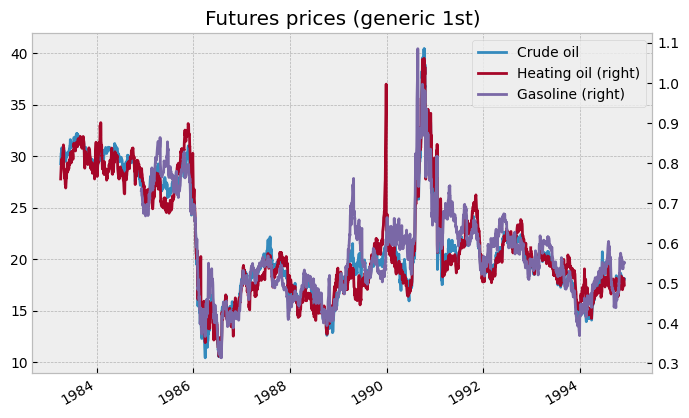

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.concat((
    cl_price['1983-04':'1994-11'],
    ho_price['1983-04':'1994-11'],
    xb_price['1984-12':'1994-11'],
), axis=1).plot(secondary_y=['Heating oil', 'Gasoline'], ax=ax);
ax.set_title('Futures prices (generic 1st)');

In fact, in the long-run $H_0$ cannot be rejected for all contracts based on both BIC and AIC.

In [10]:
pd.concat((
    adf(cl_price['1983-04':], autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':], autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-2.096128,0.246074,1.0,10729.0,-3.430960,-2.861809,-2.566913,34091.054219
Heating oil,-1.807547,0.376721,6.0,10722.0,-3.430960,-2.861810,-2.566914,-39364.573442
Gasoline,-2.250269,0.188509,0.0,10289.0,-3.430986,-2.861821,-2.566920,-38399.394192


In [11]:
pd.concat((
    adf(cl_price['1983-04':], autolag='AIC').to_frame().T,
    adf(ho_price['1983-04':], autolag='AIC').to_frame().T,
    adf(xb_price['1984-12':], autolag='AIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-2.479116,0.120639,39.0,10691.0,-3.430962,-2.861810,-2.566914,33987.603346
Heating oil,-2.039977,0.269324,36.0,10692.0,-3.430962,-2.861810,-2.566914,-39533.148967
Gasoline,-2.412608,0.138210,26.0,10263.0,-3.430987,-2.861822,-2.566920,-38426.846084


Test for two unit roots shows the $H_0$ is rejected for all assets so it would be safe to assume prices are all $I(1)$ processes.

In [12]:
pd.concat((
    adf(cl_price['1983-04':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
    adf(ho_price['1983-04':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
    adf(xb_price['1984-12':'1994-11'].diff().dropna(), autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
Crude oil,-22.389831,0.0,7.0,2924.0,-3.432588,-2.862529,-2.567296,4002.321620
Heating oil,-35.771956,0.0,2.0,2926.0,-3.432587,-2.862528,-2.567296,-15827.398507
Gasoline,-30.486435,0.0,2.0,2509.0,-3.432959,-2.862693,-2.567384,-14019.461403


## Engle-Granger test

Next, let's check if the crack spread is cointegrated. The cointegration vector is estimated by OLS and the stationarity of the residual is tested with the ADF test.
The test is done by the `coint` function in `statsmodels`. (cf. https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html)

In [13]:
price_concat = pd.concat((
    cl_price,
    ho_price,
    xb_price,
), axis=1).fillna(method='pad').dropna()

In [14]:
def coint(y: pd.Series, x: pd.DataFrame) -> pd.Series:
    """ Run the cointegration test and return a cleaned result """
    result = sm.tsa.stattools.coint(y, x)
    cleaned = {
        't_value': result[0],
        'p_value': result[1],
        'ci_0.01': result[2][0],
        'ci_0.05': result[2][1],
        'ci_0.1': result[2][2],
    }
    return pd.Series(cleaned)

In [15]:
coint_result = pd.concat((
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc[:'1994-11', 'Crude oil'],
        price_concat.loc[:'1994-11', ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

The $H_0$ is that there is no cointegration. As per GP1999, all three crack spreads are cointegrated. 

In [16]:
coint_result

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-6.648676,2.739516e-07,-4.299492,-3.744071,-3.454654
CL vs XB,-5.123246,9.709179e-05,-3.900805,-3.338563,-3.046139
CL vs HO,-5.754851,5.382539e-06,-3.900805,-3.338563,-3.046139


This seems to hold with the full sample.

In [17]:
pd.concat((
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc[:, 'Crude oil'],
        price_concat.loc[:, ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-4.287405,1.022826e-02,-4.295140,-3.741491,-3.452783
CL vs XB,-7.139897,3.970933e-09,-3.897502,-3.336723,-3.044861
CL vs HO,-3.480992,3.411803e-02,-3.897502,-3.336723,-3.044861


However the confidence level is somewhat weakend with recent data although they are at least still cointegrated at the 5% level.

In [18]:
pd.concat((
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Heating oil', 'Gasoline']]
    ).to_frame('CL vs HO + XB').T,
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Gasoline']]
    ).to_frame('CL vs XB').T,
    coint(
        price_concat.loc['2010':, 'Crude oil'],
        price_concat.loc['2010':, ['Heating oil']]
    ).to_frame('CL vs HO').T,
))

,t_value,p_value,ci_0.01,ci_0.05,ci_0.1
CL vs HO + XB,-4.700925,0.002442,-4.297334,-3.742791,-3.453726
CL vs XB,-5.307826,0.000043,-3.899167,-3.337651,-3.045505
CL vs HO,-2.877910,0.142149,-3.899167,-3.337651,-3.045505


## Crack spreads

Additionally, GP1999 tests the stationarity of the popularly traded crack spread -- 3:2:1 crack spread (CS), 1:1:0 gasoline crack spread (GCS) and 1:0:1 heating oil crack spread (HOCS).

Note that the crude oil contract is priced in barrels while the other two are priced in gallon, and there are 42 gallons per 1 barrel. Some unit conversions are required to calculate such spreads.

In [19]:
cs = (price_concat['Heating oil'].mul(42).mul(2 / 3) + 
      price_concat['Gasoline'].mul(42).mul(1 / 3) - 
      price_concat['Crude oil'])
gcs = (price_concat['Gasoline'].mul(42) - 
       price_concat['Crude oil'])
hocs = (price_concat['Heating oil'].mul(42) - 
        price_concat['Crude oil'])

As can be seen visually below, these spreads appear stationary until around 2000 after which they started to drift away from a certain level. This could be related to the financialisation of commodities. There are some evidence suggesting that index investments and speculative trades influence the commodity markets. (cf https://www.ecb.europa.eu/pub/financial-stability/fsr/focus/2011/pdf/ecb~6fdfdfce1c.fsrbox201112_04.pdf)

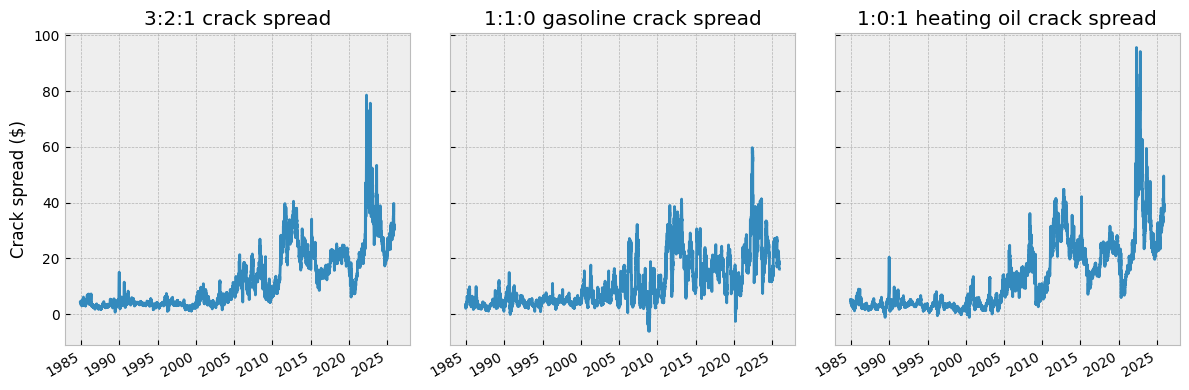

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
cs.plot(ax=ax[0])
gcs.plot(ax=ax[1])
hocs.plot(ax=ax[2])

ax[0].set_title('3:2:1 crack spread')
ax[1].set_title('1:1:0 gasoline crack spread')
ax[2].set_title('1:0:1 heating oil crack spread')
ax[0].set_ylabel('Crack spread ($)')

fig.tight_layout();

More formally, the ADF tests below show that they were stationary until Nov-1994.

In [21]:
pd.concat((
    adf(cs[:'1994-11'], autolag='BIC').to_frame().T,
    adf(gcs[:'1994-11'], autolag='BIC').to_frame().T,
    adf(hocs[:'1994-11'], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
0,-9.723857,9.387361e-17,0.0,2512.0,-3.432956,-2.862691,-2.567383,2405.195084
0,-6.067386,1.172897e-07,0.0,2512.0,-3.432956,-2.862691,-2.567383,2843.858694
0,-8.553236,9.103243e-14,0.0,2512.0,-3.432956,-2.862691,-2.567383,3535.842166


Statistically though these spreads are still stationary at the 1% confidence level even after 2000.

In [22]:
pd.concat((
    adf(cs['2000':], autolag='BIC').to_frame().T,
    adf(gcs['2000':], autolag='BIC').to_frame().T,
    adf(hocs['2000':], autolag='BIC').to_frame().T,
))

,adf,p_value,used_lag,n_obs,ci_0.01,ci_0.05,ci_0.1,ic_best
0,-3.229706,0.018328,7.0,6514.0,-3.431354,-2.861984,-2.567006,19759.069323
0,-5.603099,0.000001,0.0,6521.0,-3.431353,-2.861983,-2.567006,21216.054583
0,-3.671368,0.004534,3.0,6518.0,-3.431354,-2.861984,-2.567006,22242.021018


# Backtest

It's not entirely clear how many back contracts are used in the original analysis as they only mentioned they used *all spreads*. In this notebook, the first 6 contracts are used for the sake of simplicity. Beyond 6, there tends to be more missing prices because of inactivity.

In practice, one might want to consider liquidity of each contract to decide which one to trade as not all contract months have the same liquidity. In the case of crude oil, after certain points only June and December contracts are actually traded even though other months are listed.

In [23]:
cl_curve = get_futures_curve_snapshot('CL', datetime(2021, 12, 1), 'volume')

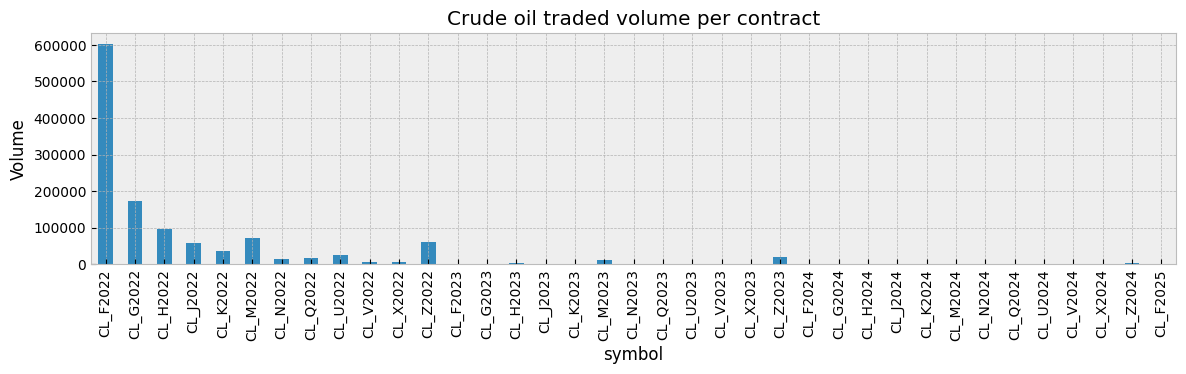

In [24]:
ax = cl_curve.loc[:'2024'].set_index('symbol')['volume'].plot(kind='bar', figsize=(14, 3));
ax.set_ylabel('Volume')
ax.set_title('Crude oil traded volume per contract');

## Crack spread

First define the instruments. `roll_rule` is defined to make sure futures are rolled on month-ends. As per the analysis done for crush spreads, some arbitrary collateral of 100k USD is used to meature futures returns. Furthermore, `contract_months` is defined to consider all delivery months unlike the commodity benchmarks which only use the subset of delivery months.

In [25]:
max_expiry = 6
contract_months = tuple(range(1, 12 + 1))
instrument = []
for i in range(1, max_expiry + 1):
    ho = InstrumentDef('HO', id=f'HO_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    xb = InstrumentDef('XB', id=f'XB_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    instrument.append(ho)
    instrument.append(xb)
    instrument.append(cl)

In [26]:
len(instrument)

18

In [27]:
engine_cs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_cs.run()

In [28]:
levels_cs = engine_cs.calculate_equity_curve(calculate_net=False).rename('Crack spread')

## Gasoline crack spread

In [29]:
max_expiry = 6
instrument = []
for i in range(1, max_expiry + 1):
    xb = InstrumentDef('XB', id=f'XB_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    instrument.append(xb)
    instrument.append(cl)

In [30]:
engine_gcs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        weights={'XB': 42 * 1000, 'CL': -1 * 1000},
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_gcs.run()

In [31]:
levels_gcs = engine_gcs.calculate_equity_curve(calculate_net=False).rename('Gasoline crack spread')

## Heating oil crack spread

In [32]:
max_expiry = 6
instrument = []
for i in range(1, max_expiry + 1):
    ho = InstrumentDef('HO', id=f'HO_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    cl = InstrumentDef('CL', id=f'CL_{i}', collateral=100_000, roll_rule=RollRule.MONTH_END.value, nth_expiry=i, contract_months=contract_months)
    instrument.append(ho)
    instrument.append(cl)

In [33]:
engine_hocs = BacktestEngine(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=instrument,
    signal=signal.CrackSpreadGP1999(
        weights={'HO': 42 * 1000, 'CL': -1 * 1000},
        ma_lookback=5,
        entry_sigma=2,
    ),
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)
engine_hocs.run()

In [34]:
levels_hocs = engine_hocs.calculate_equity_curve(calculate_net=False).rename('Heating oil crack spread')

## Performance
During the sample period tested, a mean-reversion on the crack spread worked well.

In [35]:
levels = pd.concat((
    levels_cs, levels_gcs, levels_hocs
), axis=1)

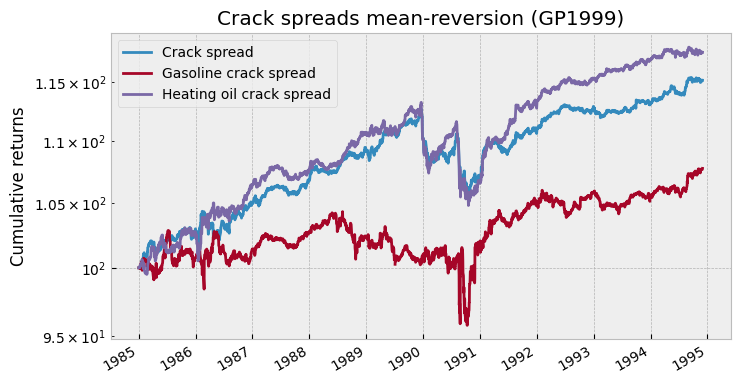

In [36]:
fig, ax = plt.subplots(figsize=(8, 4.5))
levels[:'1994-11'].plot(ax=ax, logy=True);
ax.set_title('Crack spreads mean-reversion (GP1999)')
ax.set_ylabel('Cumulative returns');

In [37]:
levels[:'1994-11'].pipe(Performance).summary()

,Crack spread,Gasoline crack spread,Heating oil crack spread
CAGR,0.014227,0.007545,0.016349
Annualised vol,0.020627,0.033099,0.023484
Sharpe ratio,0.689716,0.227943,0.696189
Max drawdown,0.063507,0.081947,0.074622
Calmar ratio,0.224014,0.092067,0.219092
Skewness,-0.359905,2.494820,-0.170715
Kurtosis,14.679044,59.252276,15.690322
Worst return,-0.011727,-0.022233,-0.013008
Worst 1d return,-0.011727,-0.022233,-0.013008
Worst 1w return,-0.017932,-0.034278,-0.019076


The underperformance in 1990 coincides with a wider divergence on the crack spread which is intuitive.

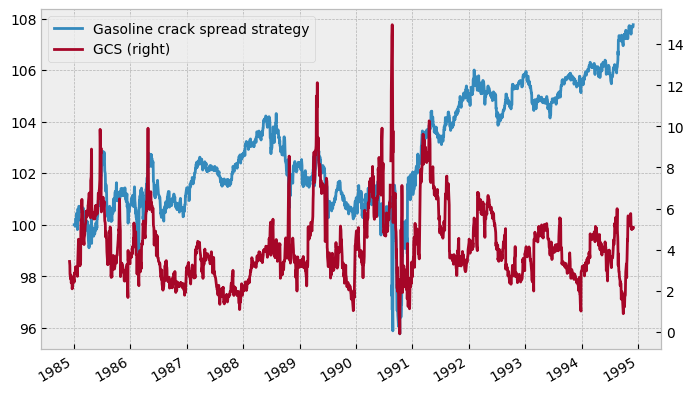

In [38]:
pd.concat((
    levels_gcs.rename('Gasoline crack spread strategy'),
    gcs.rename('GCS')
), axis=1)[:'1994-11'].plot(figsize=(8, 5), secondary_y='GCS');

## Long-term performance

...however as we saw earlier in the time-series of crack spreads, something must have changed in 2000s and the trading strategies stopped working.

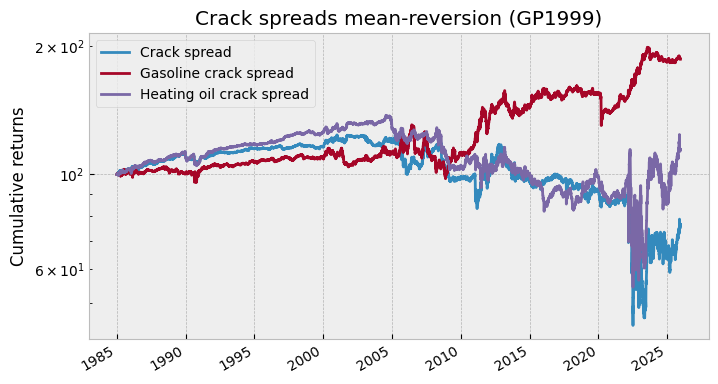

In [39]:
fig, ax = plt.subplots(figsize=(8, 4.5))
levels.plot(ax=ax, logy=True);
ax.set_title('Crack spreads mean-reversion (GP1999)')
ax.set_ylabel('Cumulative returns');

In [40]:
levels.pipe(Performance).summary()

,Crack spread,Gasoline crack spread,Heating oil crack spread
CAGR,-0.006576,0.015209,0.003302
Annualised vol,0.134168,0.060880,0.143513
Sharpe ratio,-0.049016,0.249813,0.023007
Max drawdown,0.642032,0.252041,0.603705
Calmar ratio,-0.010243,0.060342,0.005469
Skewness,1.537451,-0.427937,3.506919
Kurtosis,110.226258,28.499965,220.482849
Worst return,-0.170167,-0.064475,-0.217763
Worst 1d return,-0.170167,-0.064475,-0.217763
Worst 1w return,-0.172126,-0.076509,-0.174639


## Post publication

In [41]:
publication_date = datetime(1999, 11, 29)

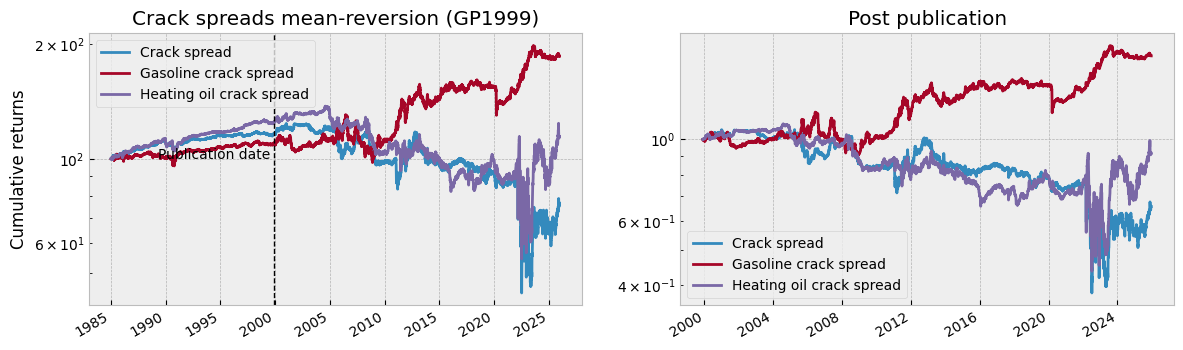

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels.plot(ax=ax[0], logy=True);
ax[0].set_title('Crack spreads mean-reversion (GP1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

# Reference
- Girma, P.B. and Paulson, A.S., 1999. Risk arbitrage opportunities in petroleum futures spreads. Journal of Futures Markets, 19(8), pp.931-955.

In [43]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 19-Dec-2025 00:02
